In [1]:
#Importing Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB


np.random.seed(0) #Setting the seed globally since sklearn uses numpy https://www.mikulskibartosz.name/how-to-set-the-global-random_state-in-scikit-learn/

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## importing the dataset and exploring

There're three columns, body, title, and category (which we're trying to classify).  
We also see there is 2481 records and none have empty values.

In [2]:
dataset = pd.read_json("articles.json")
dataset.tail()

,body,title,category
2476,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",Startups & Business
2477,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,Startups & Business
2478,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,Engineering
2479,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,Product & Design
2480,Netflix is a place where people win. They exce...,Humans Hate Being Spun: How to Practice Radica...,Startups & Business


In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2481 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB
None


Looking at one of the articles, we see that we would need to normalize all to lower case and remove special characters and keep only alphanumerical ones.

In [4]:
dataset["body"][0]

'Protecting Netflix Viewing Privacy at Scale\r\n\r\nOn the Open Connect team at Netflix, we are always working to enhance the hardware and software in the purpose-built Open Connect Appliances (OCAs) that store and serve Netflix video content. As we mentioned in a recent company blog post, since the beginning of the Open Connect program we have significantly increased the efficiency of our OCAs — from delivering 8 Gbps of throughput from a single server in 2012 to over 90 Gbps from a single server in 2016. We contribute to this effort on the software side by optimizing every aspect of the software for our unique use case — in particular, focusing on the open source FreeBSD operating system and the NGINX web server that run on the OCAs.\r\n\r\nMembers of the team will be presenting a technical session on this topic at the Intel Developer Forum (IDF16) in San Francisco this month. This blog introduces some of the work we’ve done.\r\n\r\nAdding TLS to Video Streams\r\n\r\nIn the modern in

we will factorize the categories (add a numberical id for each category).

In [5]:
target_category = dataset['category'].unique()
dataset['categoryId'] = dataset['category'].factorize()[0]
dataset.tail()

,body,title,category,categoryId
2476,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",Startups & Business,1
2477,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,Startups & Business,1
2478,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,Engineering,0
2479,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,Product & Design,2
2480,Netflix is a place where people win. They exce...,Humans Hate Being Spun: How to Practice Radica...,Startups & Business,1


There are three categories in this dataset.

In [6]:
category = dataset[['category', 'categoryId']].drop_duplicates().sort_values('categoryId')
category

,category,categoryId
0,Engineering,0
7,Startups & Business,1
57,Product & Design,2


Looking at the distribtution of the values, Startups & Business	is the most common, with Engineering being the least common.

In [7]:
dataset['category'].value_counts()

Startups & Business    1071
Product & Design        852
Engineering             558
Name: category, dtype: int64

### Cleaning up to prepare for the model.

Splitting the dataset, we will be using the body column for training our models.

In [8]:
body = dataset["body"]
category = dataset['category']

Converting all text to lower case.

In [9]:
dataset['body'] = dataset['body'].str.lower()

Removing non alphanumberical characters so they don't skew our models.

In [10]:
def keep_alphanum(body):
  reviews = ''
  for x in body:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

dataset['body'] = dataset['body'].apply(keep_alphanum)
dataset['body'][1]

'introducing winston   event driven diagnostic and remediation platform    netflix is a collection of microservices that all come together to enable the product you have come to love  operating these micro services is also distributed across the owning teams and their engineers  we do not run a central operations team managing these individual services for availability  what we do instead is to invest in tools that help netflix engineers operate their services for high availability and resiliency  today  we are going to talk about one such tool recently built for netflix engineers   winston    problem space    consider a typical mid tier micro service at netflix  it s a single purpose service hosted on aws  it uses jenkins for builds  spinnaker for deployment and atlas for monitoring  alerts are configured on top of metrics using the atlas stack language  atlas supports triggering a set of predefined actions when the alert fires  namely instance level remediation  terminate instance  r

We will remove stop words as explained earlier, we can see a few even on the first line.

In [11]:
def remove_stopwords(body):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(body)
  return [x for x in words if x not in stop_words]

dataset['body'] = dataset['body'].apply(remove_stopwords)

we will use NLTK lib for stemming/lemmatization (converting words to their root (lemma), for example cars to car)

In [12]:
def lemmatize_word(body):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in body])
dataset['body'] = dataset['body'].apply(lemmatize_word)

In [13]:
dataset.tail()

,body,title,category,categoryId
2476,early stage focus unit economic profitability ...,"At the Early Stage, Focus on Unit Economic Pro...",Startups & Business,1
2477,5 tip nail successful product launch past two ...,5 Tips to Nail a Successful Product Launch,Startups & Business,1
2478,route defensibility ai startup simple framewor...,Routes to Defensibility for your AI Startup,Engineering,0
2479,faster faster faster like talk fast left build...,Faster. Faster. Faster.,Product & Design,2
2480,netflix place people win exceed expectation co...,Humans Hate Being Spun: How to Practice Radica...,Startups & Business,1


splitting the dataset to prepare for model, x is the body of article, the training column and y is the category, what we're trying to predict.

In [14]:
x = dataset['body']
y = dataset['categoryId']

### Preparing models

we will use a scikit-learn function to vectorize our words (convert words to the count of which they're appearing in said article).  
I'll be seeing the max features parameter to limit the words to take into consideration into the most frequent words, so the models don't take long.  
according to research, with only knowing 800 lammas, you can understand 75% of the language.  
you need about **8000** lemmas to get around well written newspapers, so I'll be sitting it for that much.  
Source: https://www.bbc.com/news/world-44569277

In [15]:
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.categoryId.values)
cv = CountVectorizer(max_features = 8000)
x = cv.fit_transform(dataset.body).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (2481, 8000)
y.shape =  (2481,)


we will split our dataset into a training and a test parts, using 30% for test and 70% training.  

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 0)

print(len(x_train))
print(len(x_test))

1736
745


I'll create a function to try different models and then output the scores of these models into a pandas dataframe for comparison.

In [17]:
#create list of model and their performance
perform_list = []

def try_model(model_name):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression(max_iter=500) #increasing iterations since default 100 wasn't enough
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier()
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier()
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)
    # Get the weighted precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='weighted')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 4)),
        ('Precision', round(precision, 4)),
        ('Recall', round(recall, 4)),
        ('F1', round(f1score, 4))
         ]))


In [18]:
for mod_n in ['Logistic Regression', 
'Random Forest', 
'Multinomial Naive Bayes', 
'Support Vector Classifer', 
'Decision Tree Classifier', 
'K Nearest Neighbour', 
'Gaussian Naive Bayes']: 
    try_model(mod_n)

Test Accuracy Score of Basic Logistic Regression: % 82.6846
Precision : 0.828291914572344
Recall    : 0.8268456375838926
F1-score   : 0.826906844175004
Test Accuracy Score of Basic Random Forest: % 83.4899
Precision : 0.8413482707289907
Recall    : 0.8348993288590604
F1-score   : 0.8345453894928768
Test Accuracy Score of Basic Multinomial Naive Bayes: % 81.4765
Precision : 0.8248882915279584
Recall    : 0.8147651006711409
F1-score   : 0.8142225565247264
Test Accuracy Score of Basic Support Vector Classifer: % 81.3423
Precision : 0.8172889420661607
Recall    : 0.8134228187919463
F1-score   : 0.8132195789804654
Test Accuracy Score of Basic Decision Tree Classifier: % 66.9799
Precision : 0.7151831416010529
Recall    : 0.6697986577181209
F1-score   : 0.6700021934113914
Test Accuracy Score of Basic K Nearest Neighbour: % 69.1275
Precision : 0.7093418877677129
Recall    : 0.6912751677852349
F1-score   : 0.6905606792057581
Test Accuracy Score of Basic Gaussian Naive Bayes: % 66.5772
Precision

We find that the Random Forest model is giving the best results, so we will go with that one.

In [19]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,82.6846,0.8283,0.8268,0.8269
1,Random Forest,83.4899,0.8413,0.8349,0.8345
2,Multinomial Naive Bayes,81.4765,0.8249,0.8148,0.8142
3,Support Vector Classifer,81.3423,0.8173,0.8134,0.8132
4,Decision Tree Classifier,66.9799,0.7152,0.6698,0.6700
5,K Nearest Neighbour,69.1275,0.7093,0.6913,0.6906
6,Gaussian Naive Bayes,66.5772,0.7100,0.6658,0.6712


In [20]:
row = model_performance.iloc[model_performance['Test Accuracy'].idxmax()]
max_value = row['Test Accuracy']
max_model = row['Model']
print("The model with the most accuracy is {} at {}%".format(max_model, max_value))

The model with the most accuracy is Random Forest at 83.4899%


#### Cross Validation and Parameter optimizing for Random Forest.

I'll use GridSearchCV from science kit to perform cross validation and check for a better optimized model

I'll be keeping the defaults for the RandomForestClassifier() as is, but will change the number of estimators to see which is best.  
Keeping defaults means max_depth= None which is unlimited, at the cost of performance

In [21]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 100)
forest.fit(x_train,y_train)
y_pred_best = forest.predict(x_test)

print(accuracy_score(y_test , y_pred_best))

0.8295302013422818


In [22]:
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [100, 200, 400, 700, 1000]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= None)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

{'n_estimators': 700}

In [23]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 700)
forest.fit(x_train,y_train)
y_pred_best = forest.predict(x_test)

print(accuracy_score(y_test , y_pred_best))
print(classification_report(y_pred_best, y_test, target_names=target_category))

0.8389261744966443
                     precision    recall  f1-score   support

        Engineering       0.88      0.96      0.92       157
Startups & Business       0.90      0.78      0.83       361
   Product & Design       0.74      0.85      0.79       227

           accuracy                           0.84       745
          macro avg       0.84      0.86      0.85       745
       weighted avg       0.85      0.84      0.84       745



We see that with more estimators the accuracy barely by less than 1%, but for 7 times the time needs, I think staying with the default 100 is best.  

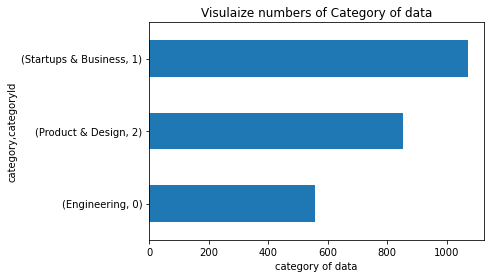

In [24]:
dataset.groupby('category').categoryId.value_counts().plot(kind = "barh")
plt.xlabel("category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

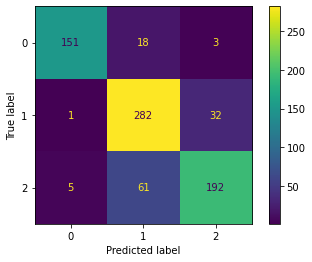

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best)).plot()

We can see from the confusion matrix that the most wrong prediction are between category 1 (Business) and 2  (Product), which makes sense given that they both have most values and probably a lot of overlap in terms used.

We will use a popular visual called word cloud to look at the popular words for each category of articles.

In [26]:
#Getting a dataframe for each category

business = dataset[dataset['categoryId'] == 1]

business = business['body']

product = dataset[dataset['categoryId'] == 2]

product = product['body']

eng = dataset[dataset['categoryId'] == 0]

eng = eng['body']

Words common in business articles:


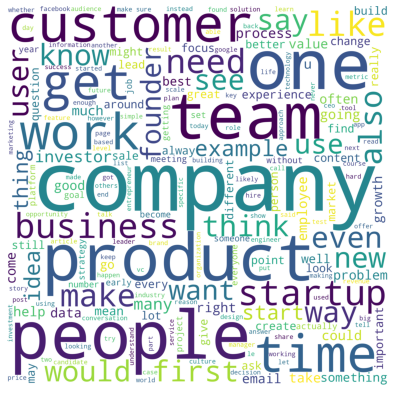

Words commoon in product articles:


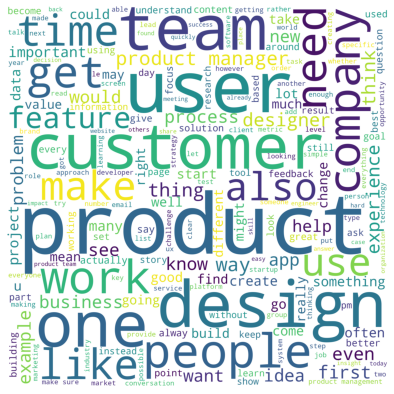

Words common in engineering articles:


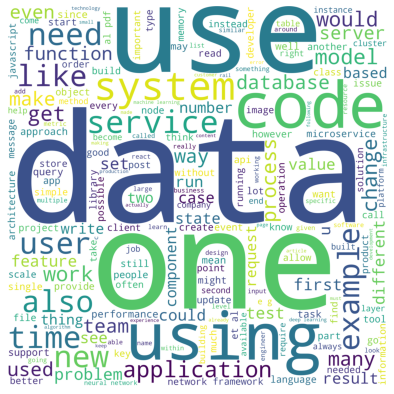

In [27]:
# we will use NLTK lib to remove stop words (words that are common in English without effect on context, like "the" or "an")

stop = set(stopwords.words('english'))

def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = stop,
    background_color = color,
    width = 2500, height = 2500).generate(cleaned_word)
    
    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

print("Words common in business articles:")
wordcloud_draw(business, 'white')

print("Words commoon in product articles:")
wordcloud_draw(product, 'white')

print("Words common in engineering articles:")
wordcloud_draw(eng, 'white')

#### Conclusion
We can see that there is a lot of of overlap between the three categories, like "Team", "User", and "Product".  
Which makes sense given that engineering makes products for businesses (the three categories we have).